In [3]:
import pandas as pd

# seleciona os dados do arquivos
# data frame (df) - molde de dados
dados = pd.read_csv('CSV_Mamíferos_Cortada.csv')
dados.head()

,Mes,Estacao,Trecho,Sentido,Trecho macro,Tipo De Pistas,Numero de Pistas,Tipo de Pavimento,Numero de Faixas,Velocidade Maxima,...,Agua?,Vegetacao Baixa?,capimAlto,Arbustos,Floresta,Local,Com filhotes?,Faixa Horario da Coleta,Faixa de Quilometragem,mamifero mais atropelado
0,4,Outono,2,JF,Baixada,Sem divisão,1,Pavimento flexível (asfalto),4,110,...,sim,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Pista de rolamento,Desconhecido,Entre 00 e 06,Entre 100 e 125,0
1,4,Outono,4,JF,Serra,Sem divisão,1,Pavimento rígido,2,60,...,sim,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Pista de rolamento,Desconhecido,Entre 06 e 12,Entre 75 e 100,0
2,5,Outono,5,JF,Serra,Sem divisão,1,Pavimento semi-flexível,2,60,...,sim,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Entre 12 e 18,Entre 75 e 100,0
3,6,Outono,7,RJ,Planalto,Defensa Metálica,2,Pavimento flexível (asfalto),4,60,...,sim,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Acostamento,Desconhecido,Entre 06 e 12,Entre 50 e 75,0
4,6,Outono,3,RJ,Serra,Defensa Metálica,2,Pavimento flexível (asfalto),4,80,...,não,Desconhecido,Desconhecido,Desconhecido,Desconhecido,Acesso/ Retorno,Desconhecido,Entre 12 e 18,Entre 100 e 125,0


In [4]:
Y_df = dados['mamifero mais atropelado']  
X_df = dados[["Mes", "Estacao", 
              "Trecho", "Sentido", "Trecho macro",
              "Tipo De Pistas", "Numero de Pistas",
              "Tipo de Pavimento", "Numero de Faixas",
              "Velocidade Maxima", "Tipo da Chuva","Intervencao",
              "Vazamento", "Agua?", "Vegetacao Baixa?","capimAlto",
              "Arbustos","Floresta","Local","Com filhotes?",
              "Faixa Horario da Coleta","Faixa de Quilometragem"]]

atributos = ["Mes", "Estacao", 
              "Trecho", "Sentido", "Trecho macro",
              "Tipo De Pistas", "Numero de Pistas",
              "Tipo de Pavimento", "Numero de Faixas",
              "Velocidade Maxima", "Tipo da Chuva","Intervencao",
              "Vazamento", "Agua?", "Vegetacao Baixa?","capimAlto",
              "Arbustos","Floresta","Local","Com filhotes?",
              "Faixa Horario da Coleta","Faixa de Quilometragem"]

valores = []

for i in X_df:
    auxi = X_df[i].unique()
    valores.append(auxi)
    

Como nossas variáveis são majoritariamente categóricas, vamos criar uma versão numérica delas.

In [5]:
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import LabelEncoder


X_encoded = X_df.apply(LabelEncoder().fit_transform)
X = X_encoded.values
print("x:", X.shape)

lb = preprocessing.LabelBinarizer()
y_ = lb.fit_transform(Y_df)

if y_.shape[1] == 1:
    y_ = np.concatenate((1 - y_, y_), axis=1)


print("y", y_.shape)

x: (13096, 22)
y (13096, 2)


Dividir em treino e teste

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(X, Y_df, test_size = 0.33,
                                                         stratify = Y_df)

In [7]:
from sklearn.naive_bayes import MultinomialNB

multinomial = MultinomialNB ()

multinomial.fit(treino_x, treino_y)
    
# testa modelo
y_predict = multinomial.predict(teste_x) # Pega as previsoes do modelo para os valores X de teste
y_true = teste_y


Matriz de confusão


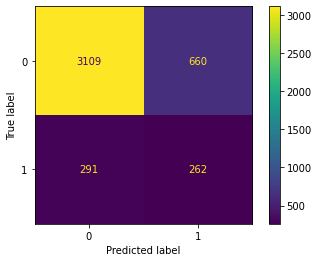

              precision    recall  f1-score   support

           0       0.91      0.82      0.87      3769
           1       0.28      0.47      0.36       553

    accuracy                           0.78      4322
   macro avg       0.60      0.65      0.61      4322
weighted avg       0.83      0.78      0.80      4322



In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("Matriz de confusão")
matriz_confusao = confusion_matrix(y_true, y_predict)
matriz = ConfusionMatrixDisplay(matriz_confusao)
matriz.plot()
plt.show()

print(classification_report(teste_y, y_predict))


Recall: De todas as classes positivas, quantas instâncias foram identificadas corretamente.

In [12]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()


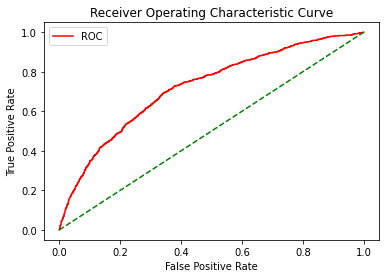

In [14]:

from sklearn.metrics import roc_curve

TargetVarScore = multinomial.predict_proba(teste_x)
fper, tper, thresholds = roc_curve(teste_y, TargetVarScore[:, 1])
plot_roc_curve(fper, tper)

Balanceando utilizando SMOTE. Primeiramente, vamos acrescentar registros que tenham a classe minoritária.

In [15]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(treino_x, treino_y)

print("Antes do balanceamento, contagem de '1': {}".format(sum(treino_y == 1)))
print("Antes do balanceamento, contagem de '0': {} \n".format(sum(treino_y == 0)))

print('Depois do balanceamento, dimensão de treino_X: {}'.format(X_res.shape))
print('Depois do balanceamento, dimensão de treino_y: {} \n'.format(y_res.shape))
  
print("Depois do balanceamento, contagem de '1': {}".format(sum(y_res == 1)))
print("Depois do balanceamento, contagem de '0': {}".format(sum(y_res == 0)))

Antes do balanceamento, contagem de '1': 1123
Antes do balanceamento, contagem de '0': 7651 

Depois do balanceamento, dimensão de treino_X: (15302, 22)
Depois do balanceamento, dimensão de treino_y: (15302,) 

Depois do balanceamento, contagem de '1': 7651
Depois do balanceamento, contagem de '0': 7651


Matriz de confusão


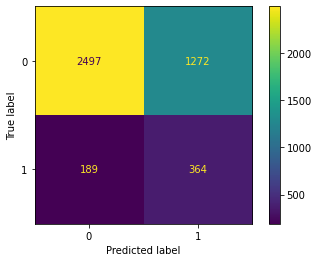

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      3769
           1       0.22      0.66      0.33       553

    accuracy                           0.66      4322
   macro avg       0.58      0.66      0.55      4322
weighted avg       0.84      0.66      0.72      4322



In [16]:
# treina o modelo com os dados balanceados
multinomial.fit(X_res, y_res )

# testa model
y_predict = multinomial.predict(teste_x) # Pega as previsoes do modelo para os valores X de teste
y_true = teste_y

print("Matriz de confusão")
matriz_confusao = confusion_matrix(y_true, y_predict)
matriz = ConfusionMatrixDisplay(matriz_confusao)
matriz.plot()
plt.show()

print(classification_report(teste_y, y_predict))


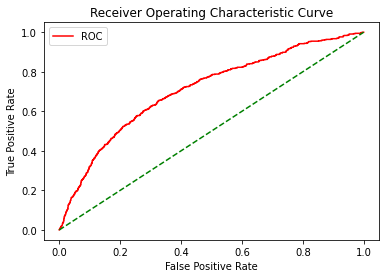

In [17]:
from sklearn.metrics import roc_curve

TargetVarScore = multinomial.predict_proba(teste_x)
fper, tper, thresholds = roc_curve(y_true, TargetVarScore[:, 1])
plot_roc_curve(fper, tper)

Podemos testar o inverso também, removendo registros da classe majoritária.

In [18]:
from imblearn.under_sampling import NearMiss
nr = NearMiss()


In [19]:
  
X_train_miss, y_train_miss = nr.fit_resample(treino_x, treino_y)

print("Antes do balanceamento, contagem de '1': {}".format(sum(treino_y == 1)))
print("Antes do balanceamento, contagem de '0': {} \n".format(sum(treino_y == 0)))

print('Depois do balanceamento, dimensão de treino_X: {}'.format(X_train_miss.shape))
print('Depois do balanceamento, dimensão de treino_y: {} \n'.format(y_train_miss.shape))
  
print("Depois do balanceamento, contagem de '1': {}".format(sum(y_train_miss == 1)))
print("Depois do balanceamento, contagem de '0': {}".format(sum(y_train_miss == 0)))

Antes do balanceamento, contagem de '1': 1123
Antes do balanceamento, contagem de '0': 7651 

Depois do balanceamento, dimensão de treino_X: (2246, 22)
Depois do balanceamento, dimensão de treino_y: (2246,) 

Depois do balanceamento, contagem de '1': 1123
Depois do balanceamento, contagem de '0': 1123


Matriz de confusão


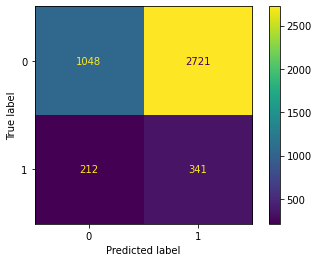

              precision    recall  f1-score   support

           0       0.83      0.28      0.42      3769
           1       0.11      0.62      0.19       553

    accuracy                           0.32      4322
   macro avg       0.47      0.45      0.30      4322
weighted avg       0.74      0.32      0.39      4322



In [20]:
# treina o modelo com dados balanceados
multinomial.fit(X_train_miss, y_train_miss)
    
# testa modelo
y_predict = multinomial.predict(teste_x) # Pega as previsoes do modelo para os valores X de teste
y_true = teste_y

print("Matriz de confusão")
matriz_confusao = confusion_matrix(y_true, y_predict)
matriz = ConfusionMatrixDisplay(matriz_confusao)
matriz.plot()
plt.show()

print(classification_report(teste_y, y_predict))


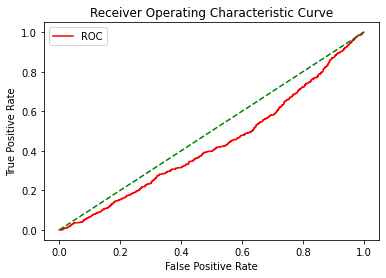

In [21]:
from sklearn.metrics import roc_curve

TargetVarScore = multinomial.predict_proba(teste_x)
fper, tper, thresholds = roc_curve(y_true, TargetVarScore[:, 1])
plot_roc_curve(fper, tper)

Agora queremos obter os resultados de fato, isso é a influencia de cada atributo na classe final.

In [47]:
y_proba = multinomial.predict_proba(X)
print(y_proba.shape)

y_prob = multinomial.feature_log_prob_
print(y_prob.shape)

classe0 = []
for i in y_prob[0]:
    prob = np.exp(i)
    classe0.append(prob)

classe1 = []
for i in y_prob[1]:
    prob = np.exp(i)
    classe1.append(prob)
    
resultados_df = pd.DataFrame()

resultados_df['Atributos'] = atributos
# resultados_df['Valores'] = valores
resultados_df['Probabilidade de ser 1'] = classe1
resultados_df['Probabilidade de ser 0'] = classe0

print(resultados_df)



(13096, 2)
(2, 22)
                  Atributos  Probabilidade de ser 1  Probabilidade de ser 0
0                       Mes                0.125364                0.133707
1                   Estacao                0.038730                0.042399
2                    Trecho                0.160454                0.194579
3                   Sentido                0.007571                0.007874
4              Trecho macro                0.018928                0.018776
5            Tipo De Pistas                0.090565                0.110690
6          Numero de Pistas                0.038439                0.037099
7         Tipo de Pavimento                0.035527                0.037099
8          Numero de Faixas                0.068433                0.072835
9         Velocidade Maxima                0.103524                0.058752
10            Tipo da Chuva                0.048923                0.054664
11              Intervencao                0.017909                0.